<a href="https://colab.research.google.com/github/tsnthlg/CapStone/blob/master/MultivarLSTM%20Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error

# Load and inspect data


Load the time series data from the file into a pandas DataFrame and display the first few rows and the data types to understand the structure of the data.


In [35]:
df = pd.read_csv('/content/synthetic_timeseries.csv')
display(df.head())
display(df.info())

,feature1,feature2,target
0,0.049671,0.858463,0.318153
1,0.086007,0.952940,0.384964
2,0.263438,0.945795,0.523763
3,0.447823,0.875109,0.591824
4,0.366003,0.904932,0.316714


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  100 non-null    float64
 1   feature2  100 non-null    float64
 2   target    100 non-null    float64
dtypes: float64(3)
memory usage: 2.5 KB


None

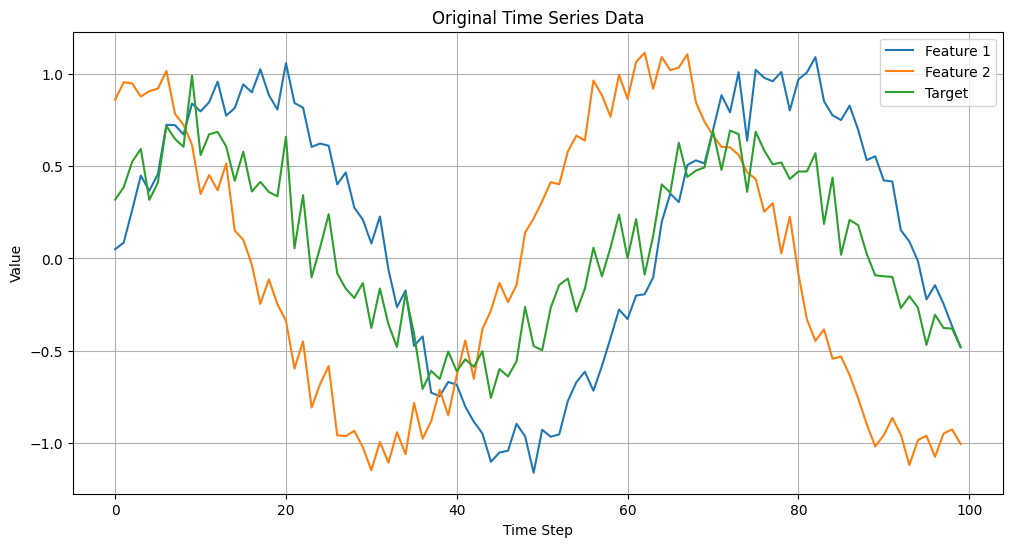

In [36]:
# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(df['feature1'], label='Feature 1')
plt.plot(df['feature2'], label='Feature 2')
plt.plot(df['target'], label='Target')
plt.title('Original Time Series Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Define global variables

In [37]:
# Global variables
TEST_SIZE = 0.2
RANDOM_STATE = 42
SEQUENCE_LENGTH = 10
FORECAST_HORIZON = 4
WINDOW_SIZE = SEQUENCE_LENGTH + FORECAST_HORIZON
BATCH_SIZE = 32

# Data preprocessing


**Reasoning**:
Prepare the data for modeling by splitting into features and target, then splitting into training and testing sets, checking for missing values, and finally scaling the features.



In [38]:
# 1. Split into features (X) and target (y)
X = df[['feature1', 'feature2', 'target']].drop('target', axis=1)
y = df['target']

# 2. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# 3. Check for missing values (based on previous inspection, there should be none)
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in X_test:", X_test.isnull().sum().sum())
print("Missing values in y_train:", y_train.isnull().sum())
print("Missing values in y_test:", y_test.isnull().sum())

# 4. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the resulting sets to verify the split
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("\nFirst 5 rows of scaled X_train:\n", X_train_scaled[:5])

Missing values in X_train: 0
Missing values in X_test: 0
Missing values in y_train: 0
Missing values in y_test: 0

Shape of X_train: (80, 2)
Shape of X_test: (20, 2)
Shape of y_train: (80,)
Shape of y_test: (20,)

First 5 rows of scaled X_train:
 [[-1.14996519  0.88213945]
 [ 0.59286359 -1.1294019 ]
 [ 0.39253193 -1.20835421]
 [-1.56227927 -0.80823482]
 [ 0.56542955  1.01744464]]


**Reasoning**:
Define a function to create sequences for LSTM input and apply it to the scaled training data to generate sequences and corresponding target values.



In [39]:
def create_sequences(data, sequence_length):
    """
    Creates sequences from time series data for LSTM input.

    Args:
        data (pd.DataFrame): The input time series data containing all features and target.
        sequence_length (int): The length of the sequences.

    Returns:
        tuple: A tuple containing:
            - X (np.ndarray): The feature sequences (including the target in the features).
            - y (np.ndarray): The target values corresponding to the sequence's end.
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Include all columns (feature1, feature2, target) in the sequence features
        X.append(data.iloc[i:(i + sequence_length)][['feature1', 'feature2', 'target']].values)
        # The target for prediction is the value at the end of the sequence
        y.append(data.iloc[i + sequence_length]['target'])
    return np.array(X), np.array(y)

# Specify the sequence length
# sequence_length = 10

# Convert scaled training data back to DataFrame for easier slicing in the function
# The scaled data (X_train_scaled) contains only features. We need to add the target (y_train)
# back to create the combined data for sequences that include the target as a feature.

# Create a DataFrame from the scaled features.
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['feature1', 'feature2'])

# Reset the index of y_train to ensure alignment with X_train_scaled_df
y_train_reset = y_train.reset_index(drop=True)

# Combine the scaled features and the target into a single DataFrame
# Ensure the column names are correct after combining
train_data_for_sequences = pd.concat([X_train_scaled_df, y_train_reset.rename('target')], axis=1)


# Generate sequences for training data
X_train_sequences, y_train_sequences = create_sequences(train_data_for_sequences, SEQUENCE_LENGTH)

# Display the shapes of the generated sequences
print("Shape of X_train_sequences:", X_train_sequences.shape)
print("Shape of y_train_sequences:", y_train_sequences.shape)

Shape of X_train_sequences: (70, 10, 3)
Shape of y_train_sequences: (70,)


**Reasoning**:
Modify the TensorFlow windowing to create sequences with the next 4 target values as the output, enabling multi-step forecasting.

In [40]:
# Combine the scaled training features and target into a single numpy array
train_data_combined = train_data_for_sequences.values

# Create a TensorFlow dataset from the combined training data
dataset = tf.data.Dataset.from_tensor_slices(train_data_combined)

# Create windowed sequences
# The window size now needs to accommodate the input sequence and the 4 future target values.
# So, window_size = sequence_length (for input) + 4 (for future targets)
# forecast_horizon = 4
# window_size = sequence_length + forecast_horizon

# Create windows
dataset = dataset.window(WINDOW_SIZE, shift=1, drop_remainder=True)

# Flatten the windows and split into features (X) and target (y)
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE))

# The features are the first 'sequence_length' steps of the window (all columns)
# The target is the 'target' column for the last 'forecast_horizon' steps of the window.
dataset = dataset.map(lambda window: (window[:SEQUENCE_LENGTH], window[SEQUENCE_LENGTH:, -1]))


# Shuffle and batch the dataset for training
# batch_size = 32
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(1)

# Display the structure of the resulting dataset
for x, y in dataset.take(1):
    print("Shape of features (X) in a batch:", x.shape)
    print("Shape of target (y) in a batch:", y.shape)
    print("\nFirst batch of features (X):\n", x.numpy())
    print("\nFirst batch of targets (y):\n", y.numpy())

Shape of features (X) in a batch: (32, 10, 3)
Shape of target (y) in a batch: (32, 4)

First batch of features (X):
 [[[-1.35140105 -0.88513603 -0.65140169]
  [ 0.80374695  0.99397055  0.60344762]
  [ 1.3174649   0.08206022  0.51908684]
  [ 0.88317819  1.37645356  0.71697167]
  [ 0.08397561  1.47561084  0.40050084]
  [-0.85941355 -1.23347062 -0.70585642]
  [ 0.6239422  -1.28836614 -0.09117213]
  [-1.30649122  1.30846971  0.05773992]
  [-0.9498185  -1.27074162 -0.47858087]
  [-1.23715925  0.9172599  -0.28756923]]

 [[ 1.3174649   0.08206022  0.51908684]
  [ 0.88317819  1.37645356  0.71697167]
  [ 0.08397561  1.47561084  0.40050084]
  [-0.85941355 -1.23347062 -0.70585642]
  [ 0.6239422  -1.28836614 -0.09117213]
  [-1.30649122  1.30846971  0.05773992]
  [-0.9498185  -1.27074162 -0.47858087]
  [-1.23715925  0.9172599  -0.28756923]
  [-1.65843376 -0.45569399 -0.50126337]
  [-1.628339    0.45106646 -0.49673289]]

 [[ 1.31423868 -0.38605026  0.47023563]
  [ 0.71108231 -0.71781286  0.23904785]

# Build LSTM model

**Reasoning**:
Design and compile an LSTM model using TensorFlow/Keras for multi-step time series forecasting.

In [24]:
# Define the LSTM model with Conv1D and additional LSTM layer
model = Sequential()
# Conv1D layer with input shape (sequence_length, number_of_features)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQUENCE_LENGTH, X_train_sequences.shape[2])))
# Add the first LSTM layer
# The output of Conv1D is (batches, new_timesteps, filters). This can be fed directly to LSTM.
model.add(LSTM(50, activation='relu', return_sequences=True)) # return_sequences=True to stack another LSTM layer
# Add the second LSTM layer
model.add(LSTM(50, activation='relu')) # No return_sequences=True for the last LSTM before Dense
# Add the first Dense layer
model.add(Dense(50, activation='relu'))
# Add the output Dense layer with 'forecast_horizon' neurons for multi-step prediction
model.add(Dense(FORECAST_HORIZON))

# Compile the model
model.compile(optimizer='adam', loss='mse') # Using Adam optimizer and Mean Squared Error loss

# Display the model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 8, 64)          │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8, 50)          │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,594 (182.01 KB)

 Trainable params: 46,594 (182.01 KB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
Define a learning rate scheduler callback to dynamically adjust the learning rate during training.

In [25]:
# Define the Learning Rate scheduler callback
# This will reduce the learning rate by a factor of 0.1 if the validation loss
# does not improve for 10 consecutive epochs.
lr_scheduler = ReduceLROnPlateau(
    monitor='loss',  # Monitor training loss
    factor=0.1,      # Reduce learning rate by this factor
    patience=10,     # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.0001,   # Lower bound on the learning rate
    verbose=1        # Print messages when learning rate is reduced
)

**Reasoning**:
Train the designed LSTM model for 100 epochs using the windowed dataset and record the training history.

In [41]:
# Train the model
history = model.fit(dataset, epochs=1000, callbacks=[lr_scheduler])

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1031 - learning_rate: 0.0010
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0987 - learning_rate: 0.0010
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1060 - learning_rate: 0.0010
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0947 - learning_rate: 0.0010
Epoch 5/1000


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1027 - learning_rate: 0.0010
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0955 - learning_rate: 0.0010
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0926 - learning_rate: 0.0010
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0918 - learning_rate: 0.0010
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0891 - learning_rate: 0.0010
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0922 - learning_rate: 0.0010
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0888 - learning_rate: 0.0010
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0886 - learning_rate: 0.0010
Epoch 13/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0840 - learning_rate: 0.0010
Epoch 14/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0830 - learning_rate: 0.0010
Epoch 15/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0795 - learning_rate: 0.0010
Epoch 16/1000
3/

**Reasoning**:
Plot the training loss over epochs to visualize the model's learning progress.

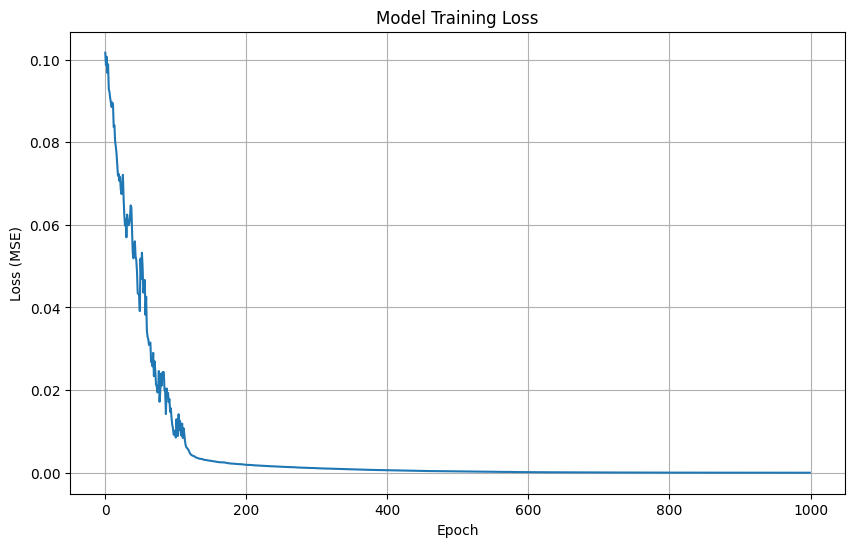

In [42]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

# Evaluate the model

**Reasoning**:
Prepare the test data for prediction using the same windowing approach as the training data, make predictions using the trained LSTM model, and display the actual and predicted values.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Forecast (first 5 multi-step predictions):
 [[-0.20477407 -0.17591351  0.19808106 -0.0524412 ]
 [-0.3582354  -0.24276735  0.42248693  0.05397313]
 [-0.0508806   0.26740137  0.14983773  0.28357926]
 [ 0.11174045  0.25362477 -0.0334217   0.2416359 ]
 [ 0.15852807  0.39465088  0.11212644 -0.01524889]]

Actuals (corresponding first 5 multi-step actual values):
 [[ 0.22282759 -0.09124024  0.3567189  -0.13518767]
 [-0.09124024  0.3567189  -0.13518767  0.02813707]
 [ 0.3567189  -0.13518767  0.02813707  0.20471631]
 [-0.13518767  0.02813707  0.20471631  0.31889292]
 [ 0.02813707  0.20471631  0.31889292  0.28674414]]


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


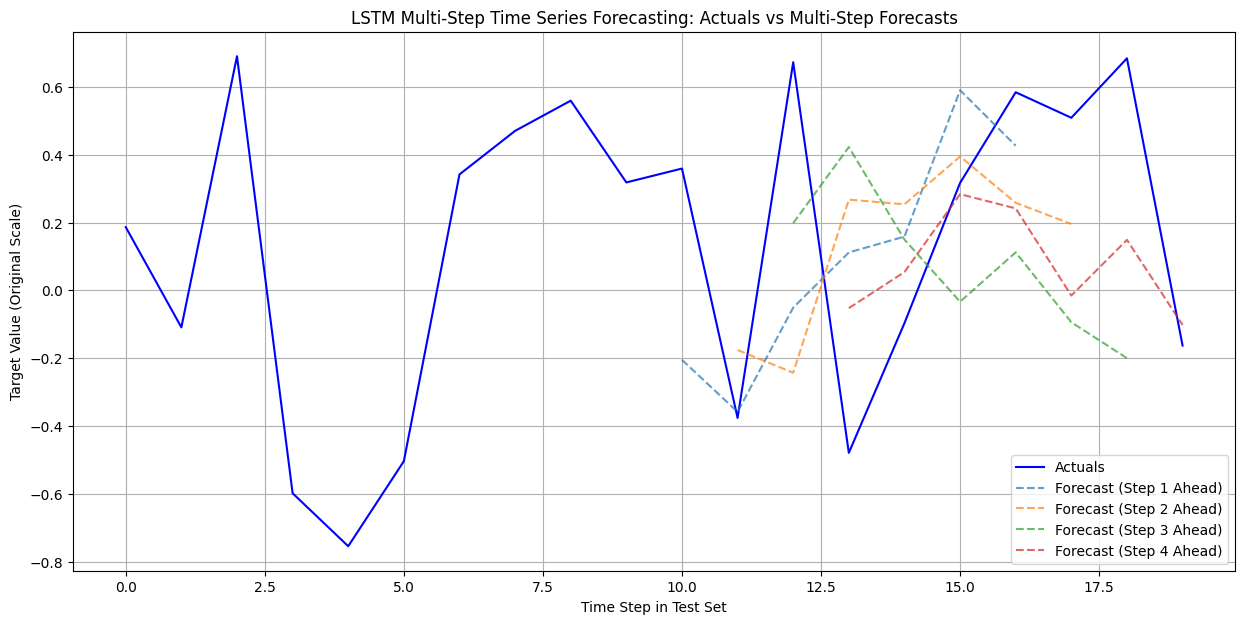

In [43]:
# Prepare the test data for prediction
# We need to combine the scaled test features and the actual test target values.
# First, scale the test features using the same scaler fitted on the training data.
X_test_scaled = scaler.transform(X_test)

# Create a DataFrame from the scaled test features.
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['feature1', 'feature2'])

# Reset the index of y_test to ensure alignment with X_test_scaled_df
y_test_reset = y_test.reset_index(drop=True)

# Combine the scaled test features and the target into a single DataFrame
test_data_for_sequences = pd.concat([X_test_scaled_df, y_test_reset.rename('target')], axis=1)

# Create a TensorFlow dataset for the test data with the same windowing
test_dataset = tf.data.Dataset.from_tensor_slices(test_data_for_sequences.values)
test_dataset = test_dataset.window(WINDOW_SIZE, shift=1, drop_remainder=True)
test_dataset = test_dataset.flat_map(lambda window: window.batch(WINDOW_SIZE))
test_dataset = test_dataset.map(lambda window: (window[:SEQUENCE_LENGTH], window[SEQUENCE_LENGTH:, -1]))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(1)


# Make predictions on the test data
predictions = model.predict(test_dataset)

# Since the predictions and actuals are scaled, we might want to inverse transform them
# to interpret the results in the original scale.
# However, the scaler was fitted on the features (feature1, feature2), not the target.
# To inverse transform the target, we need to fit a scaler on the target variable (y_train).

# Fit a scaler specifically for the target variable
target_scaler = StandardScaler()
target_scaler.fit(y_train.values.reshape(-1, 1))

# Get the actual target values from the test_dataset for comparison
# We need to extract the actual target values corresponding to the predictions.
# This requires iterating through the test_dataset to get the true y values.
actuals_scaled = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
actuals_original_scale = target_scaler.inverse_transform(actuals_scaled)

# Inverse transform the predictions and actual test target values
predictions_original_scale = target_scaler.inverse_transform(predictions)


# Print the forecast and actuals
print("Forecast (first 5 multi-step predictions):\n", predictions_original_scale[:5])
print("\nActuals (corresponding first 5 multi-step actual values):\n", actuals_original_scale[:5])

# Note: The number of actuals will be less than the number of test data points due to windowing.
# Each prediction is a sequence of 4 values.


# Combined plot: Actuals and multi-step forecasts
plt.figure(figsize=(15, 7))

# Plot the entire actual test series
# We need to use the original y_test data for the complete series.
# Since y_test_reset is aligned with the test_data_for_sequences used for windowing,
# we can plot y_test_reset.values directly.
plt.plot(y_test_reset.values, label='Actuals', color='blue')

# Plot the predictions for each forecast step
num_windows = predictions_original_scale.shape[0]
# The index in the original test set where the actuals_original_scale begins
# This is the end of the first window's input sequence.
start_index_of_actuals_for_plotting = SEQUENCE_LENGTH

for i in range(FORECAST_HORIZON):
    # Extract predictions for the i-th step across all windows
    predictions_step_i = predictions_original_scale[:, i]

    # Determine the correct x-values for plotting these predictions
    # The predictions for step i ahead from window j correspond to the actual value at index
    # (j + sequence_length + i) in the original test set data used for windowing.
    # Since the windows start from index 0 of test_data_for_sequences (aligned with y_test_reset),
    # the x-values will be from `sequence_length + i` up to `sequence_length + i + num_windows - 1`.
    forecast_x_values = range(start_index_of_actuals_for_plotting + i, start_index_of_actuals_for_plotting + i + num_windows)

    plt.plot(forecast_x_values, predictions_step_i, linestyle='--', alpha=0.7, label=f'Forecast (Step {i+1} Ahead)')

plt.title('LSTM Multi-Step Time Series Forecasting: Actuals vs Multi-Step Forecasts')
plt.xlabel('Time Step in Test Set')
plt.ylabel('Target Value (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

**Reasoning**:
Calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) to evaluate the performance of the LSTM model on the test data.

In [44]:
# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for each forecast step
print("Evaluation metrics for each forecast step:")

for i in range(FORECAST_HORIZON):
    # Extract predictions and actuals for the i-th step
    predictions_step_i = predictions_original_scale[:, i]
    actuals_step_i = actuals_original_scale[:, i]

    # Calculate Mean Squared Error (MSE) for this step
    mse_step_i = mean_squared_error(actuals_step_i, predictions_step_i)
    print(f"  Step {i+1} Ahead - Mean Squared Error (MSE): {mse_step_i:.6f}")

    # Calculate Root Mean Squared Error (RMSE) for this step
    rmse_step_i = np.sqrt(mse_step_i)
    print(f"  Step {i+1} Ahead - Root Mean Squared Error (RMSE): {rmse_step_i:.6f}")

# You can also keep the overall MSE and RMSE if desired, or remove them.
# For now, let's keep them for comparison.
overall_mse = mean_squared_error(actuals_original_scale, predictions_original_scale)
print(f"\nOverall Mean Squared Error (MSE): {overall_mse:.6f}")

overall_rmse = np.sqrt(overall_mse)
print(f"Overall Root Mean Squared Error (RMSE): {overall_rmse:.6f}")

Evaluation metrics for each forecast step:
  Step 1 Ahead - Mean Squared Error (MSE): 0.094032
  Step 1 Ahead - Root Mean Squared Error (RMSE): 0.306646
  Step 2 Ahead - Mean Squared Error (MSE): 0.089650
  Step 2 Ahead - Root Mean Squared Error (RMSE): 0.299416
  Step 3 Ahead - Mean Squared Error (MSE): 0.130098
  Step 3 Ahead - Root Mean Squared Error (RMSE): 0.360692
  Step 4 Ahead - Mean Squared Error (MSE): 0.023790
  Step 4 Ahead - Root Mean Squared Error (RMSE): 0.154241

Overall Mean Squared Error (MSE): 0.084393
Overall Root Mean Squared Error (RMSE): 0.290504


**Reasoning**:
Create bar charts to visualize the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for each forecast step.

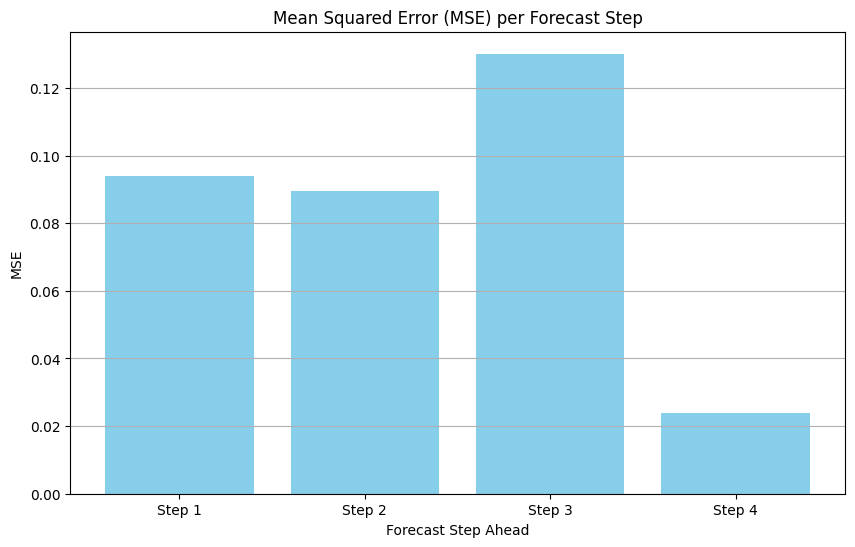

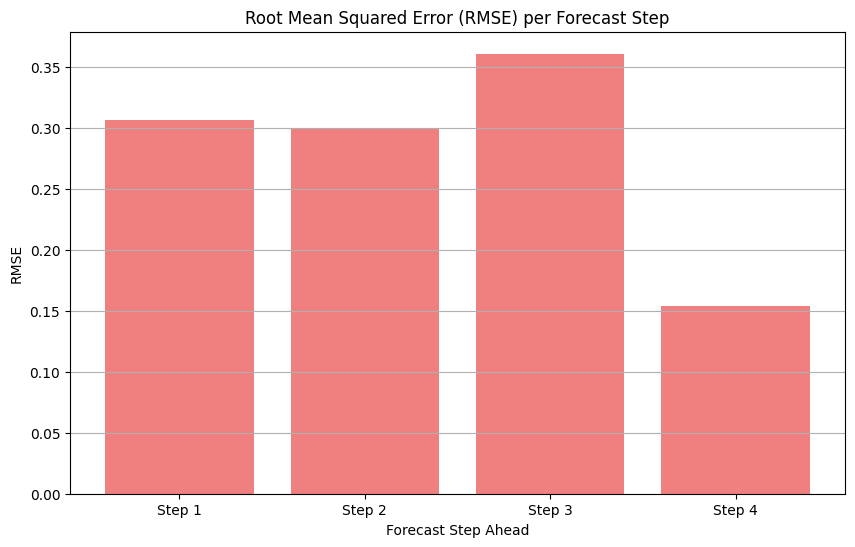

In [45]:
# Extract MSE and RMSE values for each step from the previous output
# Assuming the last execution of cell 11ef1d9e printed the metrics in the format:
#   Step X Ahead - Mean Squared Error (MSE): value
#   Step X Ahead - Root Mean Squared Error (RMSE): value
# We need to capture these values. Since we don't have direct access to the variables
# from the executed cell in this new cell, we'll re-calculate them here for plotting.

# Re-calculate MSE and RMSE for each forecast step (assuming predictions_original_scale and actuals_original_scale are available)
mse_per_step = []
rmse_per_step = []

for i in range(FORECAST_HORIZON):
    predictions_step_i = predictions_original_scale[:, i]
    actuals_step_i = actuals_original_scale[:, i]

    mse_step_i = mean_squared_error(actuals_step_i, predictions_step_i)
    rmse_step_i = np.sqrt(mse_step_i)

    mse_per_step.append(mse_step_i)
    rmse_per_step.append(rmse_step_i)

# Create labels for the x-axis
steps_labels = [f'Step {i+1}' for i in range(FORECAST_HORIZON)]

# Plotting the MSE bar chart
plt.figure(figsize=(10, 6))
plt.bar(steps_labels, mse_per_step, color='skyblue')
plt.title('Mean Squared Error (MSE) per Forecast Step')
plt.xlabel('Forecast Step Ahead')
plt.ylabel('MSE')
plt.grid(axis='y')
plt.show()

# Plotting the RMSE bar chart
plt.figure(figsize=(10, 6))
plt.bar(steps_labels, rmse_per_step, color='lightcoral')
plt.title('Root Mean Squared Error (RMSE) per Forecast Step')
plt.xlabel('Forecast Step Ahead')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()

# Save the trained model

In [48]:
# Save the trained model
model.save('lstm_time_series_model.h5')
print("Model saved to 'lstm_time_series_model.h5'")

Model saved to 'lstm_time_series_model.h5'


# load the save model and retrain

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model('lstm_time_series_model.h5')

# Display the model summary to verify it's loaded correctly
loaded_model.summary()

# Continue training the loaded model
# We can use the same dataset and callbacks defined earlier
print("\nContinuing training of the loaded model...")
history_loaded = loaded_model.fit(dataset, epochs=100, callbacks=[lr_scheduler])

# Plot the training loss of the loaded model
plt.figure(figsize=(10, 6))
plt.plot(history_loaded.history['loss'])
plt.title('Loaded Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

# Append data to df and export

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Original DataFrame shape: (100, 3)
DataFrame with predictions shape: (104, 3)

Last 10 rows of the DataFrame with predictions:
      feature1  feature2    target
94  -0.014435 -0.982375 -0.266229
95  -0.221503 -0.958640 -0.467634
96  -0.144715 -1.073074 -0.304319
97  -0.245655 -0.946992 -0.376195
98  -0.365968 -0.924605 -0.379079
99  -0.480995 -1.003488 -0.478581
100       NaN       NaN  0.950958
101       NaN       NaN  0.255085
102       NaN       NaN -0.051601
103       NaN       NaN -0.246115


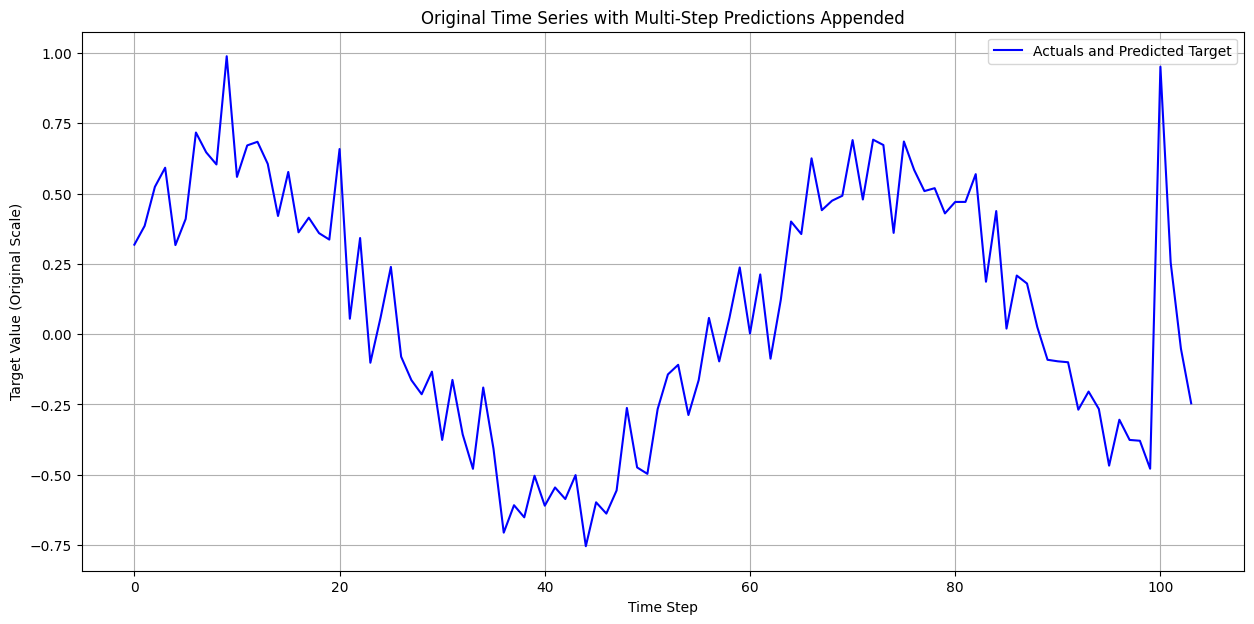

In [46]:
# Get the last window from the full data for sequence generation
# We need to get the last `sequence_length` + `forecast_horizon` points to create the last full window
# for predicting the next `forecast_horizon` values.

# Re-create the full_data_for_sequences and target_scaler within this cell
# Scale the entire feature set using the scaler fitted on the training data (assuming scaler is available from previous cells).
# Combine the scaled features and the target into a single DataFrame for the *entire* dataset
X_scaled_full = scaler.transform(df[['feature1', 'feature2']])
X_scaled_full_df = pd.DataFrame(X_scaled_full, columns=['feature1', 'feature2'])
y_full_reset = df['target'].reset_index(drop=True)
full_data_for_sequences = pd.concat([X_scaled_full_df, y_full_reset.rename('target')], axis=1)

# Fit a scaler specifically for the target variable on the full dataset
target_scaler = StandardScaler()
target_scaler.fit(df['target'].values.reshape(-1, 1))


# The full_data_for_sequences DataFrame was created and scaled earlier.
# The last window for prediction starts at index len(full_data_for_sequences) - window_size
last_window_data = full_data_for_sequences.iloc[-WINDOW_SIZE:].values

# Reshape the last window data to match the input shape of the model: (1, sequence_length, number_of_features)
# The features for prediction are the first `sequence_length` steps of this window
last_window_features = last_window_data[:SEQUENCE_LENGTH].reshape(1, SEQUENCE_LENGTH, last_window_data.shape[1])

# Make a prediction using the last window
predicted_values_scaled = model.predict(last_window_features)

# Inverse transform the predicted values back to the original scale using the target scaler
predicted_values_original_scale = target_scaler.inverse_transform(predicted_values_scaled)

# The prediction is a multi-step forecast (forecast_horizon values).
# We need to decide how to add this to the DataFrame.
# For simplicity, let's add the first predicted value as a new row to the original DataFrame,
# and potentially the subsequent predicted values as well if the user intends to extend the time series.
# For this request, let's add the first predicted value as a new row for now.

# Create a new row (or rows) for the DataFrame with the predicted values.
# Since the model predicts 'forecast_horizon' steps ahead, the first prediction
# corresponds to the time step immediately following the last time step in the original data.
# The subsequent predictions correspond to the steps after that.

new_data_rows = []
for i in range(FORECAST_HORIZON):
    # Create a new row for the i-th predicted step.
    # We don't have actual features for these future steps, so we can set them to NaN or some placeholder if needed.
    # For now, let's just add the predicted target value.
    # A more complete approach would involve using a multi-output model or recursive forecasting.
    # Given the current model predicts multiple steps at once, let's add all predicted steps as new rows.
    new_row = {'target': predicted_values_original_scale[0, i]}
    # You might want to add placeholder values for 'feature1' and 'feature2'
    # new_row['feature1'] = np.nan # Or some predicted feature value
    # new_row['feature2'] = np.nan # Or some predicted feature value
    new_data_rows.append(new_row)

# Convert the new rows to a DataFrame
new_rows_df = pd.DataFrame(new_data_rows)

# Append the new rows to the original DataFrame
# Ensure the index is handled correctly. We can reset the index of the original df first.
df_reset = df.reset_index(drop=True)
df_with_predictions = pd.concat([df_reset, new_rows_df], ignore_index=True)


print("Original DataFrame shape:", df.shape)
print("DataFrame with predictions shape:", df_with_predictions.shape)
print("\nLast 10 rows of the DataFrame with predictions:\n", df_with_predictions.tail(10))

# Optionally, visualize the original data and the appended predictions
plt.figure(figsize=(15, 7))
plt.plot(df_with_predictions['target'], label='Actuals and Predicted Target', color='blue')
plt.title('Original Time Series with Multi-Step Predictions Appended')
plt.xlabel('Time Step')
plt.ylabel('Target Value (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Export the DataFrame with predictions to a CSV file
df_with_predictions.to_csv('time_series_with_predictions.csv', index=False)
print("DataFrame with predictions exported to 'time_series_with_predictions.csv'")

DataFrame with predictions exported to 'time_series_with_predictions.csv'


# Optional: backtest on train and test

**Reasoning**:
Prepare the entire dataset for prediction using the same windowing approach, run the multi-step prediction on the full dataset, and plot the actuals with the overlaid multi-step forecasts.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


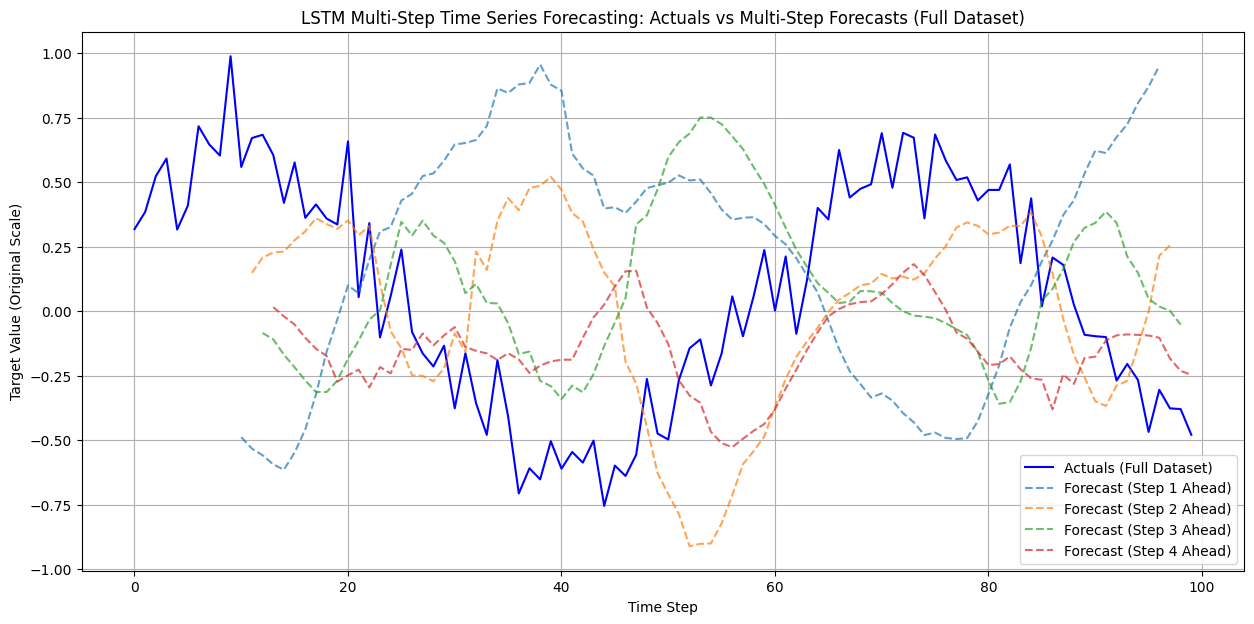

In [47]:
# Prepare the entire dataset for prediction
# Scale the entire feature set using the scaler fitted on the training data.
# We need to re-create the scaler and fit it on the entire dataset for consistent scaling
# if we want to predict on the whole dataset. However, using the scaler fitted on training
# data is more realistic for evaluating performance on unseen data (even if we are now
# applying it to the full dataset for visualization purposes). Let's stick to the scaler
# fitted on the training data for consistency with the previous steps.

# Combine the scaled features and the target into a single DataFrame for the *entire* dataset
# First, scale the features of the entire dataset.
X_scaled_full = scaler.transform(df[['feature1', 'feature2']])

# Create a DataFrame from the scaled full features.
X_scaled_full_df = pd.DataFrame(X_scaled_full, columns=['feature1', 'feature2'])

# Use the original target column from the full dataframe, reset index for concatenation
y_full_reset = df['target'].reset_index(drop=True)

# Combine the scaled full features and the target into a single DataFrame
full_data_for_sequences = pd.concat([X_scaled_full_df, y_full_reset.rename('target')], axis=1)


# Create a TensorFlow dataset for the entire data with the same windowing
# We use the same window_size (sequence_length + forecast_horizon)
full_dataset = tf.data.Dataset.from_tensor_slices(full_data_for_sequences.values)
full_dataset = full_dataset.window(WINDOW_SIZE, shift=1, drop_remainder=True)
full_dataset = full_dataset.flat_map(lambda window: window.batch(WINDOW_SIZE))
full_dataset = full_dataset.map(lambda window: (window[:SEQUENCE_LENGTH], window[SEQUENCE_LENGTH:, -1]))
full_dataset = full_dataset.batch(BATCH_SIZE).prefetch(1) # Use batching for prediction as well


# Make predictions on the entire dataset
predictions_full = model.predict(full_dataset)

# Inverse transform the predictions back to the original scale using the target scaler
# target_scaler was fitted on the training target data in the previous cell.
# If that cell was not run, this will cause an error.
# To make this cell independent, we need to fit the target_scaler here as well.

# Fit a scaler specifically for the target variable on the full dataset
target_scaler = StandardScaler()
target_scaler.fit(df['target'].values.reshape(-1, 1))

predictions_full_original_scale = target_scaler.inverse_transform(predictions_full)

# Get the actual target values from the full_dataset for comparison
actuals_full_scaled = np.concatenate([y.numpy() for x, y in full_dataset], axis=0)
actuals_full_original_scale = target_scaler.inverse_transform(actuals_full_scaled)


# Combined plot: Entire Actuals and multi-step forecasts
plt.figure(figsize=(15, 7))

# Plot the entire actual time series
# We need to use the original target values for the full plot.
plt.plot(df['target'].values, label='Actuals (Full Dataset)', color='blue')

# Plot the multi-step forecasts
num_windows_full = predictions_full_original_scale.shape[0]
# The starting index for plotting forecasts needs to consider the windowing on the full dataset.
# The actuals corresponding to the predictions start after the first sequence_length + forecast_horizon - 1 points of the full data.
# Similar to the test set plotting, the first window ends at index sequence_length + forecast_horizon - 1 in the original full dataset.
# The plots for each window's forecast should start at the end of that window's input sequence.

for i in range(FORECAST_HORIZON):
    # Extract predictions for the i-th step across all windows
    predictions_step_i_full = predictions_full_original_scale[:, i]

    # Determine the correct x-values for plotting these predictions on the full dataset scale
    # The predictions for step i ahead from window j correspond to the actual value at index
    # (j + sequence_length + i) in the original full dataset.
    # Since the windows start from index 0 of full_data_for_sequences (aligned with df['target'].values),
    # the x-values will be from `sequence_length + i` up to `sequence_length + i + num_windows_full - 1`.
    forecast_x_values_full = range(SEQUENCE_LENGTH + i, SEQUENCE_LENGTH + i + num_windows_full)

    # Ensure we don't exceed the bounds of the original data when plotting forecast x-values
    # This can happen if the last window's forecast extends beyond the end of the original data.
    # We should only plot forecast points that have a corresponding index in the original data.
    valid_forecast_indices = [idx for idx in forecast_x_values_full if idx < len(df)]
    valid_predictions = predictions_step_i_full[:len(valid_forecast_indices)]


    plt.plot(valid_forecast_indices, valid_predictions, linestyle='--', alpha=0.7, label=f'Forecast (Step {i+1} Ahead)')


plt.title('LSTM Multi-Step Time Series Forecasting: Actuals vs Multi-Step Forecasts (Full Dataset)')
plt.xlabel('Time Step')
plt.ylabel('Target Value (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()